# Simulation Design

In [1]:
!pip install multiprocess
!pip install pyreadr
!git clone https://github.com/maxhuppertz/hdmpy.git

fatal: destination path 'hdmpy' already exists and is not an empty directory.


In [2]:
import sys
sys.path.insert(1, "./hdmpy")
import hdmpy as hdm

In [3]:
import numpy as np
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors

# Simulation Design 1

In [4]:
# Set seed
np.random.seed(0)
B1 = 100
Naive = np.zeros( B1 )
Orthogonal = np.zeros( B1 )

In [7]:
for i in range( 0, B1 ):
    n = 1000
    p = 100
    beta = ( 1 / (np.arange( 1, p + 1 ) ** 2 ) ).reshape( p , 1 )
    gamma = ( 1 / (np.arange( 1, p + 1 ) ** 2 ) ).reshape( p , 1 )

    mean = 0
    sd = 1
    X = np.random.normal( mean , sd, n * p ).reshape( n, p )

    D = ( X @ gamma ) + np.random.normal( mean , sd, n ).reshape( n, 1 )/4 # We reshape because in r when we sum a vecto with a matrix it sum by column
    
    # DGP 
    Y = 10*D + ( X @ beta ) + np.random.normal( mean , sd, n ).reshape( n, 1 )

    # single selection method
    r_lasso_estimation = hdm.rlasso( np.concatenate( ( D , X ) , axis  =  1 ) , Y , post = True ) # Regress main equation by lasso

    coef_array = r_lasso_estimation.est[ 'coefficients' ].iloc[ 2:, :].to_numpy()    # Get "X" coefficients 

    SX_IDs = np.where( coef_array != 0 )[0]

    # In case all X coefficients are zero, then regress Y on D
    if sum(SX_IDs) == 0 : 
        Naive[ i ] = sm.OLS( Y , sm.add_constant(D) ).fit().summary2().tables[1].round(3).iloc[ 1, 0 ] 

    # Otherwise, then regress Y on X and D (but only in the selected coefficients)
    elif sum( SX_IDs ) > 0 :
        X_D = np.concatenate( ( D, X[:, SX_IDs ] ) , axis = 1 )
        Naive[ i ] = sm.OLS( Y , sm.add_constant( X_D ) ).fit().summary2().tables[1].round(3).iloc[ 1, 0]

    # In both cases we save D coefficient
        
    # Regress residuals. 
    resY = hdm.rlasso( X , Y , post = False ).est[ 'residuals' ]
    resD = hdm.rlasso( X , D , post = False ).est[ 'residuals' ]
    Orthogonal[ i ] = sm.OLS( resY , sm.add_constant( resD ) ).fit().summary2().tables[1].round(3).iloc[ 1, 0]

In [8]:
Orto_breaks = [-1.2, -1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]
Naive_breaks = [-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1, 1.2]

Text(0.5, 0, 'Naive')

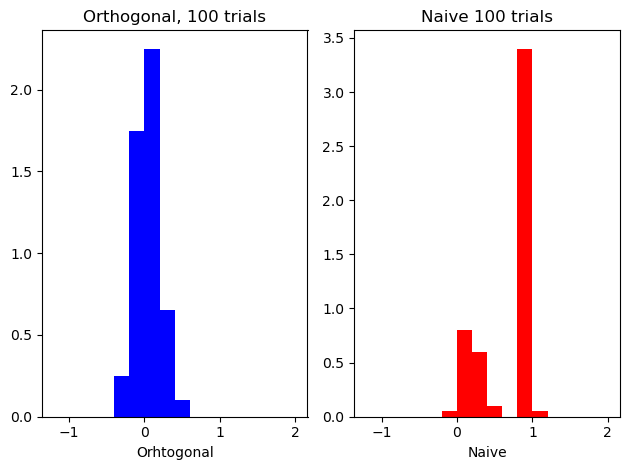

In [10]:
fig, axs = plt.subplots(1, 2, sharex= True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist( Orthogonal - 10 , range = (-2, 2), density = True , bins = Orto_breaks, color ='blue')
axs[1].hist( Naive - 10, range = (-2, 2), density = True , bins = Naive_breaks, color = 'red' )

axs[0].title.set_text('Orthogonal, 100 trials')
axs[1].title.set_text('Naive 100 trials', )

axs[0].set_xlabel( 'Orhtogonal' )
axs[1].set_xlabel( 'Naive' )


# Simulation Design 2

In [11]:
# Set seed
np.random.seed(0)
B2=1000
Naive = np.zeros( B2 )
Orthogonal = np.zeros( B2 )

In [13]:
for i in range( 0, B2 ):
    n = 1000
    p = 100
    beta = ( 1 / (np.arange( 1, p + 1 ) ** 2 ) ).reshape( p , 1 )
    gamma = ( 1 / (np.arange( 1, p + 1 ) ** 2 ) ).reshape( p , 1 )

    mean = 0
    sd = 1
    X = np.random.normal( mean , sd, n * p ).reshape( n, p )

    D = ( X @ gamma ) + np.random.normal( mean , sd, n ).reshape( n, 1 )/4 # We reshape because in r when we sum a vecto with a matrix it sum by column
    Y = 10*D + ( X @ beta ) + np.random.normal( mean , sd, n ).reshape( n, 1 )

    # single selectin method
    r_lasso_estimation = hdm.rlasso( np.concatenate( ( D , X ) , axis  =  1 ) , Y , post = True )

    coef_array = r_lasso_estimation.est[ 'coefficients' ].iloc[ 2:, :].to_numpy()

    SX_IDs = np.where( coef_array != 0 )[0]

    if sum(SX_IDs) == 0 : 
        Naive[ 0 ] = sm.OLS( Y , sm.add_constant(D) ).fit().summary2().tables[1].round(3).iloc[ 1, 0 ]

    elif sum( SX_IDs ) > 0 :
        X_D = np.concatenate( ( D, X[:, SX_IDs ] ) , axis = 1 )
        Naive[ i ] = sm.OLS( Y , sm.add_constant( X_D ) ).fit().summary2().tables[1].round(3).iloc[ 1, 0]


    resY = hdm.rlasso( X , Y , post = True ).est[ 'residuals' ]
    resD = hdm.rlasso( X , D , post = True ).est[ 'residuals' ]
    Orthogonal[ i ] = sm.OLS( resY , sm.add_constant( resD ) ).fit().summary2().tables[1].round(3).iloc[ 1, 0]

Text(0.5, 0, 'Naive')

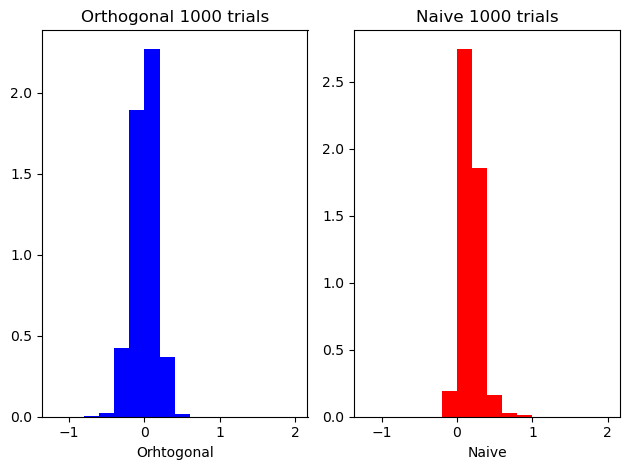

In [14]:
fig, axs = plt.subplots(1, 2, sharex= True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist( Orthogonal - 10 , range = (-2, 2), density = True , bins = Orto_breaks, color ='blue')
axs[1].hist( Naive - 10, range = (-2, 2), density = True , bins = Naive_breaks,  color ='red' )

axs[0].title.set_text('Orthogonal 1000 trials')
axs[1].title.set_text('Naive 1000 trials')

axs[0].set_xlabel( 'Orhtogonal' )
axs[1].set_xlabel( 'Naive' )


# Simulation Design 3

In [16]:
# Set seed
np.random.seed(0)
B3=10000
Naive = np.zeros( B3 )
Orthogonal = np.zeros( B3 )

In [17]:
for i in range( 0, B3 ):
    n = 1000
    p = 100
    beta = ( 1 / (np.arange( 1, p + 1 ) ** 2 ) ).reshape( p , 1 )
    gamma = ( 1 / (np.arange( 1, p + 1 ) ** 2 ) ).reshape( p , 1 )

    mean = 0
    sd = 1
    X = np.random.normal( mean , sd, n * p ).reshape( n, p )

    D = ( X @ gamma ) + np.random.normal( mean , sd, n ).reshape( n, 1 )/4 # We reshape because in r when we sum a vecto with a matrix it sum by column
    Y = 10*D + ( X @ beta ) + np.random.normal( mean , sd, n ).reshape( n, 1 )

    # single selectin method
    r_lasso_estimation = hdm.rlasso( np.concatenate( ( D , X ) , axis  =  1 ) , Y , post = True )

    coef_array = r_lasso_estimation.est[ 'coefficients' ].iloc[ 2:, :].to_numpy()

    SX_IDs = np.where( coef_array != 0 )[0]

    if sum(SX_IDs) == 0 : 
        Naive[ 0 ] = sm.OLS( Y , sm.add_constant(D) ).fit().summary2().tables[1].round(3).iloc[ 1, 0 ]

    elif sum( SX_IDs ) > 0 :
        X_D = np.concatenate( ( D, X[:, SX_IDs ] ) , axis = 1 )
        Naive[ i ] = sm.OLS( Y , sm.add_constant( X_D ) ).fit().summary2().tables[1].round(3).iloc[ 1, 0]


    resY = hdm.rlasso( X , Y , post = True ).est[ 'residuals' ]
    resD = hdm.rlasso( X , D , post = True ).est[ 'residuals' ]
    Orthogonal[ i ] = sm.OLS( resY , sm.add_constant( resD ) ).fit().summary2().tables[1].round(3).iloc[ 1, 0]

Text(0.5, 0, 'Naive')

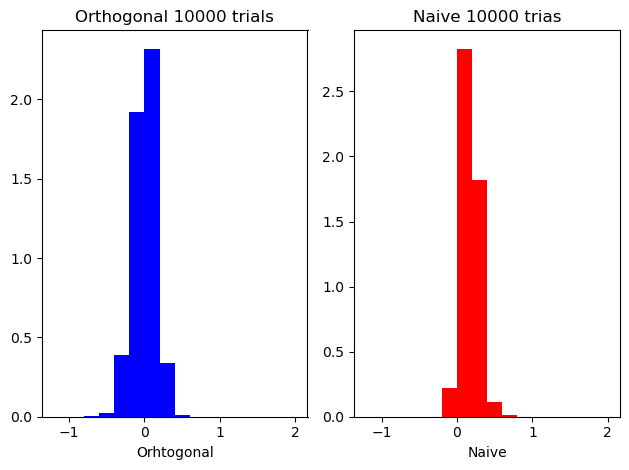

In [18]:
fig, axs = plt.subplots(1, 2, sharex= True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist( Orthogonal - 10 , range = (-2, 2), density = True , bins = Orto_breaks, color ='blue' )
axs[1].hist( Naive - 10, range = (-2, 2), density = True , bins = Naive_breaks, color = 'red' )

axs[0].title.set_text('Orthogonal 10000 trials')
axs[1].title.set_text('Naive 10000 trias')

axs[0].set_xlabel( 'Orhtogonal' )
axs[1].set_xlabel( 'Naive' )


# Interpretation

The distribution of the histograms is different because they are grouped at various points. When B, what is the number of trials, is higher, the distribution is bigger. Also, the orthogonal should be centered in zero and the Naive should be centered in numbers higher than zero. The last one is biased to the right.

The econometric explanation is based on the approach to data modeling. For the orthogonal distribution, it is assumed that the features (variables) are orthogonal to each other, meaning that they are not correlated. When the errors are orthogonal to each other, it means that they are not correlated and that there is no systematic bias in the relationship between the dependent variable and the dependent variables. This is desirable because it implies that the regression model effectively captures the relationship between variables without additional bias. Zero-centering of the distribution can arise due to the way the model is specified, such as including an intercept or by standardizing variables. On the other hand, for the Naïve distribution, the bias to the right may arise from the nature of the data and the way the conditional probabilities of the variables are modeled. This could be related to the distribution of errors in a regression model. If errors have an asymmetric distribution, such as a right-weighted (positively biased) tail distribution, this can affect how relationships between variables are modeled.


# Parallel computing

Using parallel computing, the running time is lower. The multiprocessing module allows you to create multiple child processes, each of which can execute code independently. These processes can take advantage of the multiple CPU cores available on your machine, resulting in workload distribution and, in many cases, a significant reduction in execution time..
For example (B=100) 

Without using parallel computing, for the simulation design 1, the running time is 5 minutes

In [4]:
import multiprocessing
import time

In [2]:
from multiprocessing import cpu_count
print(cpu_count())

8


In [19]:
def sleep(sleep_sec=0.5):
    print(f'Sleeping for {sleep_sec} seconds')
    time.sleep(sleep_sec)
    print('Finished sleeping')

if __name__ == "__main__":
    start_time = time.perf_counter()
    processes = []

    # Creates 100 processes then starts them
    for i in range(100):
        p = multiprocessing.Process(target=sleep, args=(1.0,))
        p.start()
        processes.append(p)

    # Joins all the processes
    for p in processes:
        p.join()

    finish_time = time.perf_counter()
    tiempo=finish_time-start_time

    print("With Parallel computing, the running time is ", tiempo, "minutes")

With Parallel computing, the running time is  4.026202299981378 minutes
